In [1]:
# source: https://learning.quantum.ibm.com/tutorial/grovers-algorithm

In [2]:
!pip install qiskit[visualization] --quiet
!pip install qiskit-ibm-runtime --quiet
!pip install qiskit-aer --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 340.8/340.8 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.4/69.4 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 96.1 MB/s eta 0:00:00


In [3]:
import math

from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_distribution, plot_histogram
from qiskit_ibm_runtime.fake_provider import FakeAuckland

In [4]:
def grover_oracle(marked_states):
    """Build a Grover oracle for multiple marked states
    Here we assume all input marked states have the same number of bits

    Parameters:
        marked_states (str or list): Marked states of oracle

    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle
    """

    if not isinstance(marked_states, list):
        marked_states = [marked_states]

    num_qubits = len(marked_states[0])
    qc = QuantumCircuit(num_qubits)

    # Mark each target state in the input list
    for target in marked_states:
        rev_target = target[::-1]
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        qc.x(zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)
    return qc

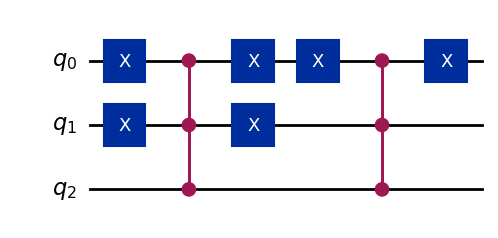

In [5]:
marked_states = ["100", "110"]

oracle = grover_oracle(marked_states)
oracle.draw(output="mpl")

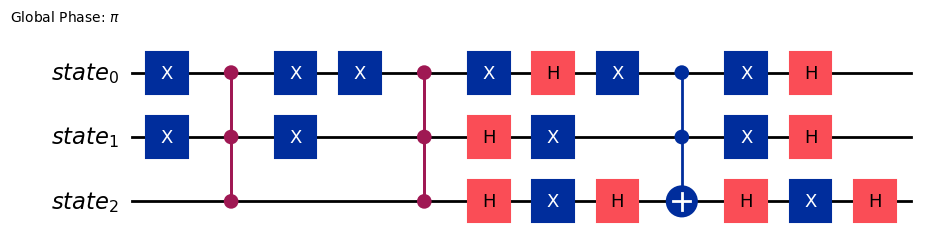

In [6]:
grover_op = GroverOperator(oracle)
grover_op.decompose().draw(output="mpl")

In [7]:
# optimal number of iterations: ca. (pi/4) * sqrt(N/M) --> where N = 2^n for n qubits, and M = how many times marked valeus are there to be found)

optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_op.num_qubits)))
)

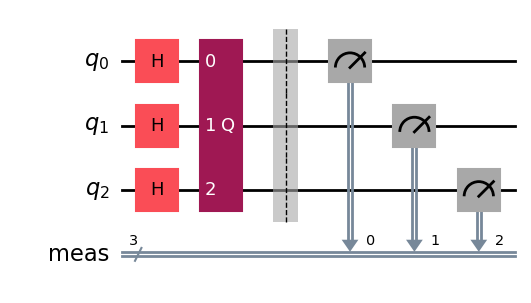

In [8]:
qc = QuantumCircuit(grover_op.num_qubits)

# Create even superposition of all basis states
qc.h(range(grover_op.num_qubits))

# Apply Grover operator the optimal number of times
qc.compose(grover_op.power(optimal_num_iterations), inplace=True)

# Measure all qubits
qc.measure_all()
qc.draw(output="mpl")

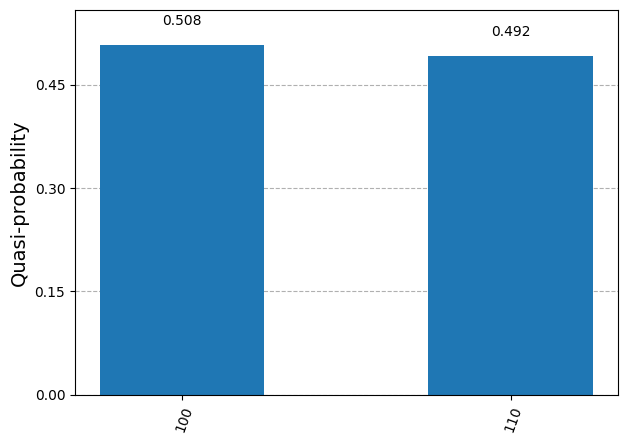

In [9]:
# Simulate the circuit - in an ideal (noiseless) case
backend = Aer.get_backend('aer_simulator')
counts = backend.run(transpile(qc, backend), shots=1000).result().get_counts()

plot_distribution(counts)

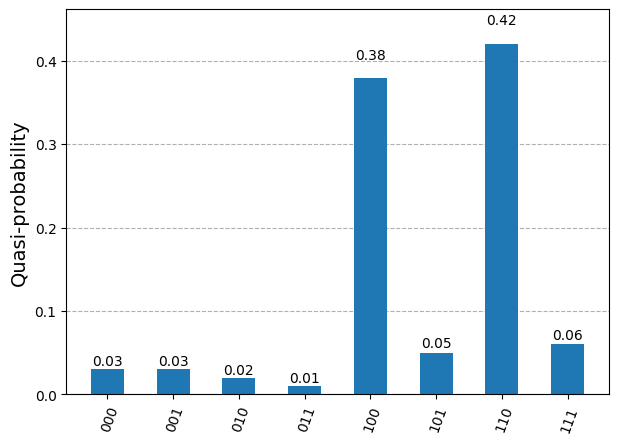

In [10]:
# Simulate the circuit - in a (more) realistic (noisy) case
backend = FakeAuckland()
counts = backend.run(transpile(qc, backend), shots=100).result().get_counts()

plot_distribution(counts)